<a href="https://colab.research.google.com/github/ashithapallath/MMM_Modeling_with_Mediation_Assumption/blob/main/Assessment2_mmm_modeling__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2 : Marketing Mix Modeling (Google as Mediator)

In this assessment, I am working with a **2-year weekly marketing dataset** that includes:
* Paid media spends (Facebook, TikTok, Snapchat, Google, etc.)
* Direct response levers (Email/SMS campaigns)
* Pricing and promotions
* Followers and other engagement metrics
* Revenue (the outcome we want to explain)

---

## What I need to do:
The task is to build a **machine learning model** that explains **Revenue** as a function of all these inputs, while keeping a **causal perspective** in mind.

A key part of this assignment is the **mediator assumption**:
* Social/display channels (like Facebook, TikTok, Snapchat) don’t just drive sales directly.
* Instead, they **stimulate search intent**, which increases **Google spend**, and then **Google drives revenue**.
* So, Google spend acts as a **mediator** in the chain → **Social/Display → Google → Revenue**.

---

## My approach:
* **Data preparation:** handle seasonality, trend, missing values, zero spends, and scaling.
* **Modeling:** build a **two-stage model**  
  - Stage 1: Predict Google spend from social/display inputs.  
  - Stage 2: Predict Revenue using Google + other features.  
* **Validation:** use **time-series-safe cross-validation** (no look-ahead) and regularization.
* **Diagnostics:** check performance, residuals, and do sensitivity analysis for **Price** and **Promotions**.
* **Insights:** identify the strongest revenue drivers, risks (e.g., collinearity, mediated effects), and practical recommendations for a marketing team.

---

In short: This is not just about fitting a model, but about **measuring how marketing actions (social, Google, promos, pricing) truly drive revenue**, while avoiding biased conclusions.


In [1]:
# 0. Setup & reproducibility
import os
import random
import math
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deterministic seeds
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)

import numpy as np
np.random.seed(RANDOM_SEED)

# sklearn reproducibility
import sklearn
from sklearn.utils import check_random_state

# Visualization + data
import pandas as pd
import matplotlib.pyplot as plt

# Models & tools
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
import joblib

# Optional (explainability)
try:
    import lightgbm as lgb
except Exception:
    lgb = None

print("Environment ready. sklearn:", sklearn.__version__)

Environment ready. sklearn: 1.6.1


In [2]:
import pandas as pd
from pathlib import Path

# Preferred dataset filenames
PREFERRED_NAMES = [
    '/Assessment 2 - MMM Weekly.csv',
    'marketing_weekly.csv',
    'Marketing_weekly.csv',
    'data.csv',
    'marketing.csv'
]

# Detect dataset path
DATA_PATH = None
for p in PREFERRED_NAMES:
    if Path(p).exists():
        DATA_PATH = p
        break

if DATA_PATH is None and Path('/mnt/data').exists():
    for p in Path('/mnt/data').glob('*.csv'):
        if p.name.startswith("._") or "__MACOSX" in str(p):
            continue
        DATA_PATH = str(p)
        break

if DATA_PATH is None:
    raise FileNotFoundError(
        "No valid CSV detected. Please upload your CSV or rename it to one of the preferred names."
    )

print("Using dataset:", DATA_PATH)

# Load CSV
df = pd.read_csv(DATA_PATH)

# Normalize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Confirm 'week' column exists
if "week" not in df.columns:
    raise ValueError(f"'week' column not found. Columns detected: {df.columns.tolist()}")

print("Dataset loaded successfully. Columns:", df.columns.tolist())
print("Initial shape:", df.shape)
df.head()


Using dataset: /Assessment 2 - MMM Weekly.csv
Dataset loaded successfully. Columns: ['week', 'facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send', 'revenue']
Initial shape: (104, 12)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [3]:
# 2. Normalize column names and map likely fields
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

expected_map = {
    'revenue': ['revenue', 'sales', 'net_revenue'],
    'google': ['google', 'google_spend', 'paid_search', 'search_spend'],
    'facebook': ['facebook', 'facebook_spend', 'meta_spend'],
    'tiktok': ['tiktok', 'tiktok_spend'],
    'instagram': ['instagram', 'instagram_spend'],
    'snapchat': ['snapchat', 'snapchat_spend'],
    'email': ['email', 'emails_send', 'email_sends', 'email_count'],
    'sms': ['sms', 'sms_send', 'sms_sends', 'sms_count'],
    'price': ['price', 'avg_price', 'average_price'],
    'followers': ['followers', 'social_followers', 'insta_followers'],
    'promotions': ['promotions', 'promo_flag', 'promo']
}

found = {}
for key, candidates in expected_map.items():
    for cand in candidates:
        if cand in df.columns:
            found[key] = cand
            break

print("Detected columns mapping:", found)

# Must-have fields check
required_keys = ['revenue', 'google', 'facebook', 'tiktok', 'snapchat',
                 'email', 'sms', 'price', 'promotions']
missing = [k for k in required_keys if k not in found]
if missing:
    raise ValueError(f"Missing required fields in dataset: {missing}")


Detected columns mapping: {'revenue': 'revenue', 'google': 'google_spend', 'facebook': 'facebook_spend', 'tiktok': 'tiktok_spend', 'instagram': 'instagram_spend', 'snapchat': 'snapchat_spend', 'email': 'emails_send', 'sms': 'sms_send', 'price': 'average_price', 'followers': 'social_followers', 'promotions': 'promotions'}


In [4]:

# 3. Parse date and set weekly index
date_col = None
for c in df.columns:
    if 'date' in c or 'week' in c:
        date_col = c
        break
if date_col is None:
    raise ValueError("No date/week column detected. Ensure dataset contains a date column.")

# Parse to datetime
df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')

# Set index and sort
df = df.set_index(date_col).sort_index()

# Use weekly Sunday frequency to match dataset
start, end = df.index.min(), df.index.max()
weekly_index = pd.date_range(start=start, end=end, freq='W-SUN')
df = df.reindex(weekly_index)

# Flag observed rows
raw_dates = pd.to_datetime(pd.read_csv(DATA_PATH)[date_col], dayfirst=True, errors='coerce')
df['observed'] = df.index.isin(raw_dates)

# Check missing values
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing.head(12))
df.head()


Missing values per column:
 facebook_spend      0
google_spend        0
tiktok_spend        0
instagram_spend     0
snapchat_spend      0
social_followers    0
average_price       0
promotions          0
emails_send         0
sms_send            0
revenue             0
observed            0
dtype: int64


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,observed
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,True
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,True
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,True
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,True
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,True


In [5]:
# 4. Preprocessing
REVENUE_COL = found['revenue']
GOOGLE_COL = found.get('google')
FB_COL = found.get('facebook')
TT_COL = found.get('tiktok')
SNAP_COL = found.get('snapchat')
EMAIL_COL = found.get('email')
SMS_COL = found.get('sms')
PRICE_COL = found.get('price')
FOLLOWERS_COL = found.get('followers')
PROMO_COL = found.get('promotions')

df_model = df.dropna(subset=[REVENUE_COL]).copy()

# Improved zero-handling: Impute with 10% of median & create flags
media_cols = [c for c in [FB_COL, TT_COL, SNAP_COL, GOOGLE_COL] if c is not None and c in df_model.columns]

for media_col in media_cols:
    # Calculate median of non-zero spends
    non_zero_mask = df_model[media_col] > 0
    if non_zero_mask.any():
        median_spend = df_model[non_zero_mask][media_col].median()
        # Create a flag for zero spends
        df_model[f'{media_col}_is_zero'] = (df_model[media_col] == 0).astype(int)
        # Impute zeros with 10% of median (small value instead of zero)
        df_model.loc[df_model[media_col] == 0, media_col] = median_spend * 0.1
    else:
        # If all zeros, use a very small value
        df_model[f'{media_col}_is_zero'] = 1
        df_model[media_col] = 0.01

num_cols = df_model.select_dtypes('number').columns.tolist()
for c in num_cols:
    if df_model[c].isna().any():
        if c == REVENUE_COL:
            continue
        df_model[c] = df_model[c].fillna(0)

print("Rows used for modeling:", len(df_model))

Rows used for modeling: 104


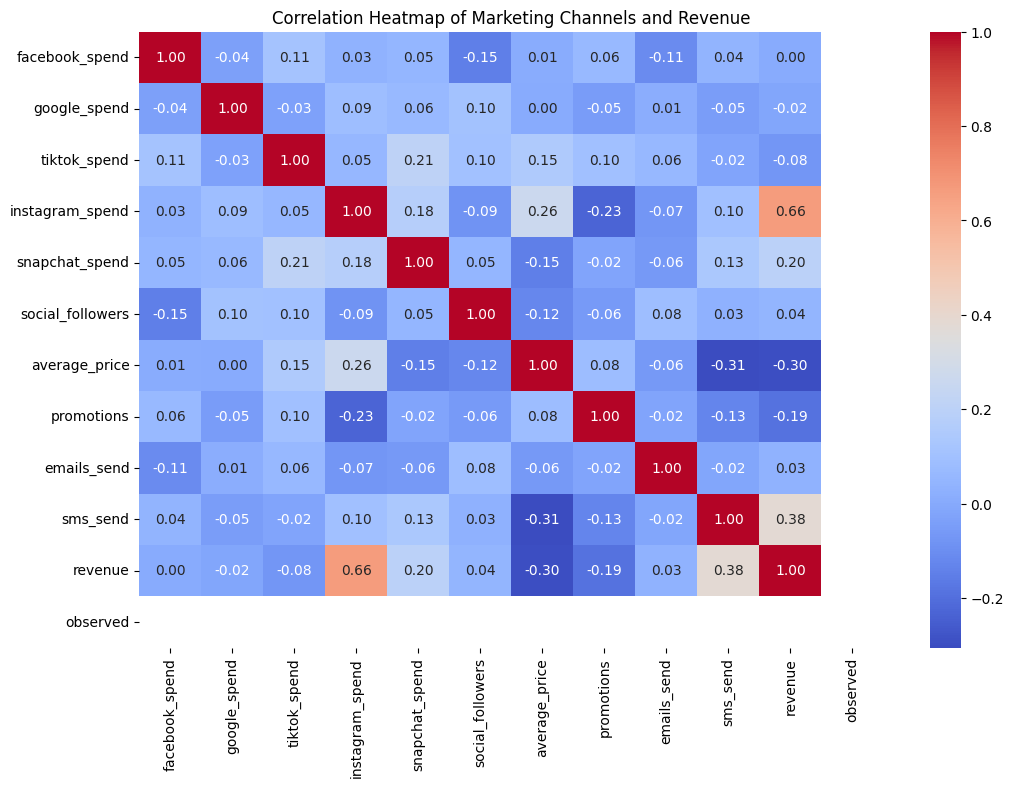

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Marketing Channels and Revenue")
plt.show()

In [7]:
# 5. Adstock implementation
import numpy as np
def adstock(series, decay):
    """Geometric adstock: out[t] = x[t] + decay * out[t-1]"""
    out = np.zeros(len(series))
    prev = 0.0
    for i, x in enumerate(series):
        out[i] = x + decay * prev
        prev = out[i]
    return out

def apply_adstock_df(df_in, media_cols, decay_map):
    df_out = df_in.copy()
    for m in media_cols:
        decay = decay_map.get(m, 0.5)
        df_out[f'{m}_adstock'] = adstock(df_in[m].fillna(0).values, decay=decay)
        df_out[f'{m}_log1p'] = np.log1p(df_out[f'{m}_adstock'])
    return df_out

print('Adstock helper ready')

Adstock helper ready


In [8]:
# 6. Feature engineering
X = df_model.copy().sort_index()
X['trend'] = np.arange(len(X))
# Pandas may warn about .weekofyear in some versions replace with .week if needed
try:
    X['weekofyear'] = X.index.weekofyear
except Exception:
    X['weekofyear'] = X.index.isocalendar().week

X['week_sin'] = np.sin(2 * np.pi * X['weekofyear'] / 52)
X['week_cos'] = np.cos(2 * np.pi * X['weekofyear'] / 52)

if PRICE_COL in X.columns:
    X['price_lag1'] = X[PRICE_COL].shift(1).fillna(method='bfill')
    X['price_pct_change'] = (X[PRICE_COL] - X['price_lag1']) / (X['price_lag1'] + 1e-9)

media_cols = [c for c in [FB_COL, TT_COL, SNAP_COL, GOOGLE_COL] if c is not None and c in X.columns]
decay_map = {m:0.5 for m in media_cols}
X = apply_adstock_df(X, media_cols, decay_map)

for comm in [EMAIL_COL, SMS_COL]:
    if comm and comm in X.columns:
        X[f'{comm}_log1p'] = np.log1p(X[comm].fillna(0))

if PROMO_COL and PROMO_COL in X.columns:
    X['promo_flag'] = (X[PROMO_COL].fillna(0) > 0).astype(int)
if FOLLOWERS_COL and FOLLOWERS_COL in X.columns:
    X['followers_log'] = np.log1p(X[FOLLOWERS_COL].fillna(0))

X = X.dropna()
print('Final modeling rows:', len(X))

Final modeling rows: 104


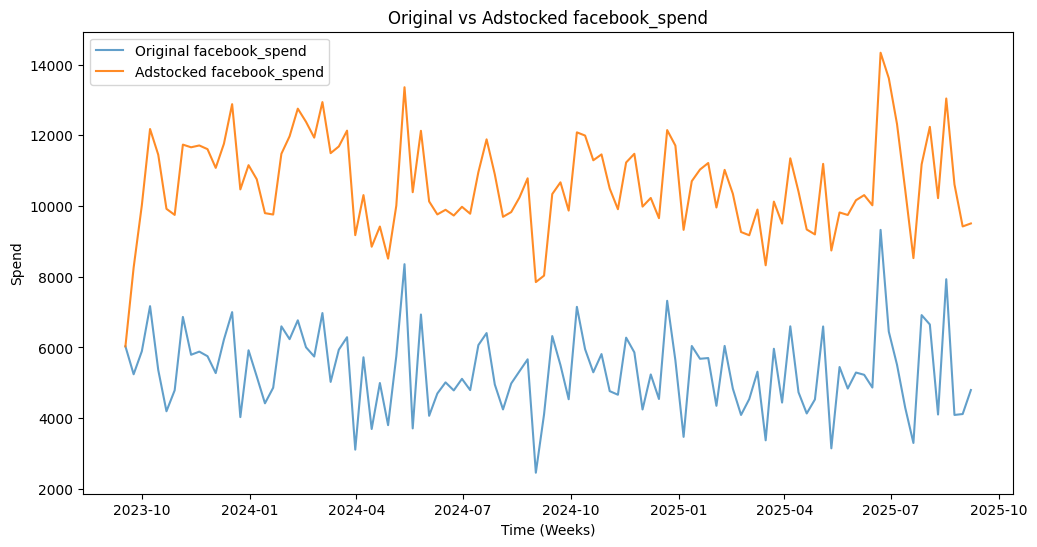

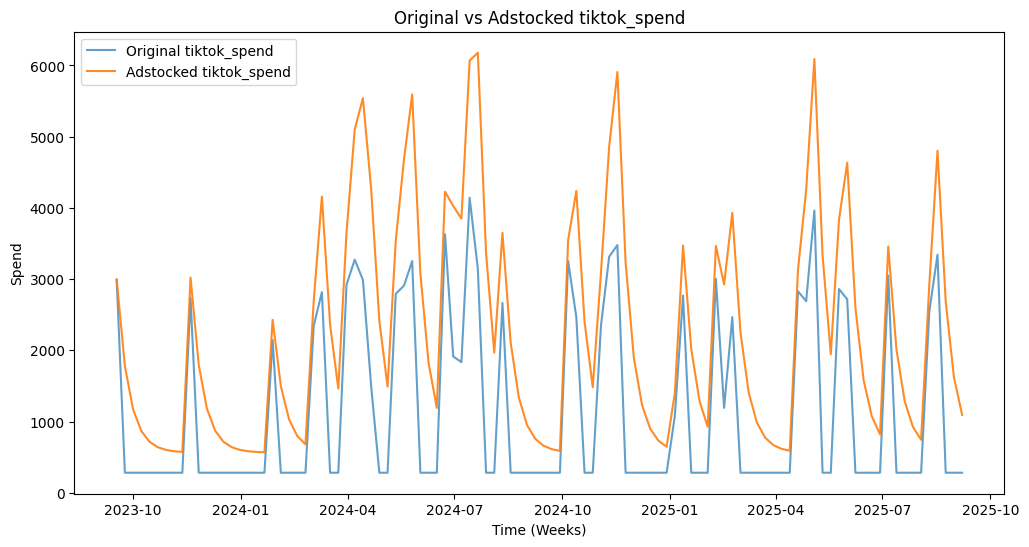

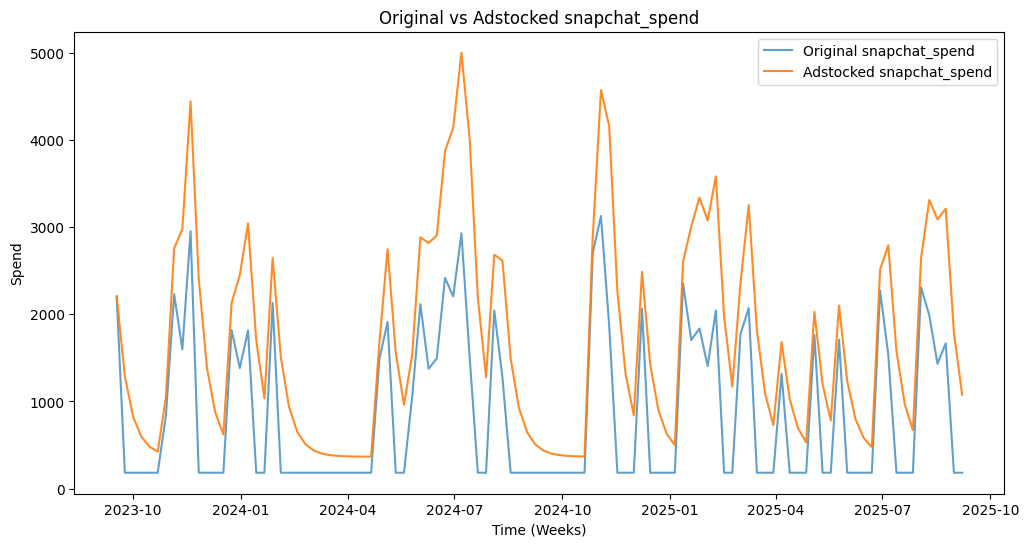

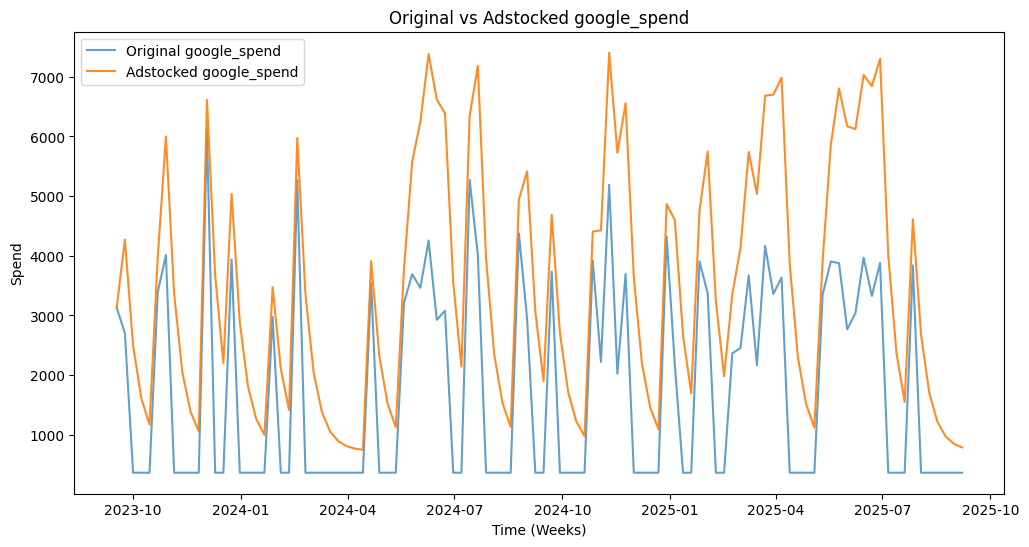

In [9]:
import matplotlib.pyplot as plt

# Visualize original vs adstocked spends
for col in media_cols:
    adstock_col = f"{col}_adstock"
    if adstock_col in X.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(X[col], label=f"Original {col}", alpha=0.7)
        plt.plot(X[adstock_col], label=f"Adstocked {col}", alpha=0.9)
        plt.title(f"Original vs Adstocked {col}")
        plt.xlabel("Time (Weeks)")
        plt.ylabel("Spend")
        plt.legend()
        plt.show()


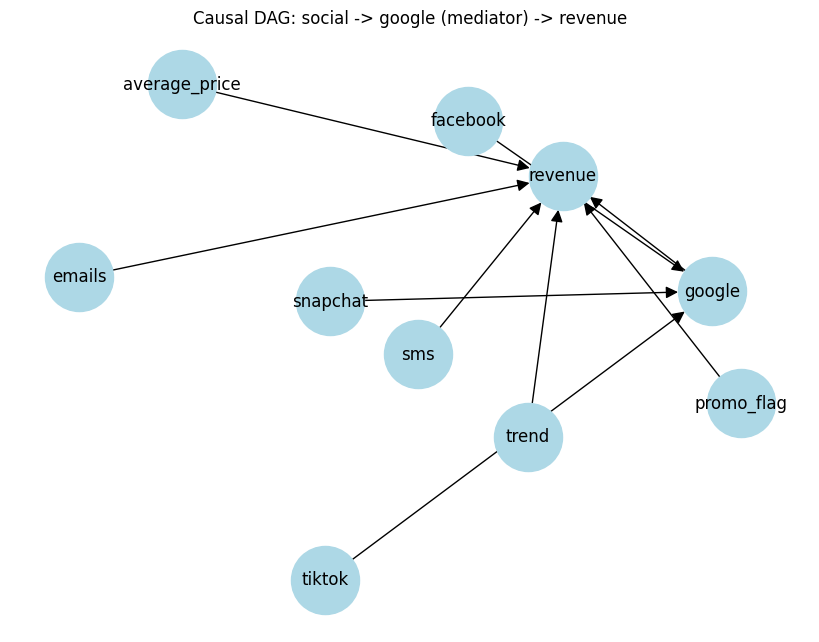

In [10]:
# 7. Causal DAG visualization (explicit assumptions)
import networkx as nx
import matplotlib.pyplot as plt

dag = nx.DiGraph()
dag.add_edges_from([
    ("facebook", "google"),
    ("tiktok", "google"),
    ("snapchat", "google"),
    ("google", "revenue"),
    ("average_price", "revenue"),
    ("promo_flag", "revenue"),
    ("emails", "revenue"),
    ("sms", "revenue"),
    ("trend", "revenue")
])
plt.figure(figsize=(8,6))
pos = nx.spring_layout(dag, seed=42)
nx.draw(dag, pos, with_labels=True, node_color='lightblue', node_size=2400, arrowsize=18)
plt.title("Causal DAG: social -> google (mediator) -> revenue")
plt.show()


In [11]:
# 8. Candidate features
base_features = ['trend', 'week_sin', 'week_cos']
media_features = [f'{m}_log1p' for m in media_cols if m is not None]
comm_features = [f'{c}_log1p' for c in [EMAIL_COL, SMS_COL] if c and f'{c}_log1p' in X.columns]
other_features = []
if PRICE_COL in X.columns:
    other_features += [PRICE_COL, 'price_pct_change']
if 'promo_flag' in X.columns:
    other_features += ['promo_flag']
if 'followers_log' in X.columns:
    other_features += ['followers_log']

feature_cols = base_features + media_features + comm_features + other_features
print('Feature columns:', feature_cols)

Feature columns: ['trend', 'week_sin', 'week_cos', 'facebook_spend_log1p', 'tiktok_spend_log1p', 'snapchat_spend_log1p', 'google_spend_log1p', 'emails_send_log1p', 'sms_send_log1p', 'average_price', 'price_pct_change', 'promo_flag', 'followers_log']


In [12]:
# 9. Stage 1: Predict Google (mediator) with time-series OOF
if GOOGLE_COL is None or GOOGLE_COL not in X.columns:
    raise ValueError("Google column required for mediator approach but not found.")

stage1_features = [f for f in feature_cols if 'google' not in f]
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
X1 = X.copy()
y1 = X1[GOOGLE_COL].values

pred_google_oof = np.zeros(len(X1))
fold_assign = np.zeros(len(X1), dtype=int) - 1
fold = 0
for train_idx, val_idx in tscv.split(X1):
    Xtr = X1.iloc[train_idx][stage1_features]
    ytr = y1[train_idx]
    Xval = X1.iloc[val_idx][stage1_features]
    en = ElasticNetCV(l1_ratio=[0.1,0.5,0.9], alphas=[0.1,1.0,10.0], cv=3, random_state=RANDOM_SEED)
    en.fit(Xtr, ytr)
    pred_google_oof[val_idx] = en.predict(Xval)
    fold_assign[val_idx] = fold
    fold += 1

final_stage1 = ElasticNet(l1_ratio=en.l1_ratio_, alpha=en.alpha_)
final_stage1.fit(X1[stage1_features], y1)
X['google_pred_oof'] = pred_google_oof
X['google_pred_full'] = final_stage1.predict(X1[stage1_features])

Path('outputs').mkdir(exist_ok=True)
joblib.dump(final_stage1, 'outputs/stage1_google_model.joblib')
print('Stage1 done. OOF RMSE:', math.sqrt(mean_squared_error(y1, pred_google_oof)))

Stage1 done. OOF RMSE: 1884.6143028750403


In [13]:
# 10. Stage 2: Revenue modeling (ElasticNet baseline)
X2 = X.copy()
if 'google_pred_oof' not in X2.columns:
    raise ValueError("google_pred_oof missing. Stage1 must run first.")

stage2_features = [c for c in feature_cols if 'google' not in c]
stage2_features = ['google_pred_oof'] + [c for c in stage2_features if c != 'google_pred_oof']
print('Stage2 features:', stage2_features)

X_stage2 = X2[stage2_features].copy()
y_stage2 = X2[REVENUE_COL].values

scaler = StandardScaler()
X_stage2_scaled = scaler.fit_transform(X_stage2)
joblib.dump(scaler, 'outputs/stage2_scaler.joblib')

tscv2 = TimeSeriesSplit(n_splits=5)
en_cv = ElasticNetCV(l1_ratio=[0.1,0.5,0.9], alphas=[0.01,0.1,1,10], cv=tscv2, random_state=RANDOM_SEED)
en_cv.fit(X_stage2_scaled, y_stage2)
print('ElasticNet CV alpha, l1_ratio:', en_cv.alpha_, en_cv.l1_ratio_)

pred_oof_en = np.zeros(len(X_stage2))
for train_idx, val_idx in tscv2.split(X_stage2):
    Xtr = scaler.transform(X_stage2.iloc[train_idx])
    Xval = scaler.transform(X_stage2.iloc[val_idx])
    en = ElasticNet(l1_ratio=en_cv.l1_ratio_, alpha=en_cv.alpha_)
    en.fit(Xtr, y_stage2[train_idx])
    pred_oof_en[val_idx] = en.predict(Xval)

en_rmse = math.sqrt(mean_squared_error(y_stage2, pred_oof_en))
en_mae = mean_absolute_error(y_stage2, pred_oof_en)
print('ElasticNet OOF RMSE:', en_rmse, 'MAE:', en_mae)

X_final = X2.copy()
X_final['google_pred'] = X_final['google_pred_full']
final_features = ['google_pred'] + [c for c in stage2_features if c != 'google_pred_oof']
X_final_data = X_final[final_features]
X_final_scaled = scaler.fit_transform(X_final_data)
final_en = ElasticNet(l1_ratio=en_cv.l1_ratio_, alpha=en_cv.alpha_)
final_en.fit(X_final_scaled, X_final[REVENUE_COL].values)
joblib.dump(final_en, 'outputs/stage2_elasticnet.joblib')

Stage2 features: ['google_pred_oof', 'trend', 'week_sin', 'week_cos', 'facebook_spend_log1p', 'tiktok_spend_log1p', 'snapchat_spend_log1p', 'emails_send_log1p', 'sms_send_log1p', 'average_price', 'price_pct_change', 'promo_flag', 'followers_log']
ElasticNet CV alpha, l1_ratio: 1.0 0.1
ElasticNet OOF RMSE: 93899.68547755442 MAE: 63916.39774256459


['outputs/stage2_elasticnet.joblib']

In [14]:
# 11.BUSINESS METRICS

import joblib
import numpy as np

# Load Stage 2 artifacts
scaler = joblib.load("outputs/stage2_scaler.joblib")
model2 = joblib.load("outputs/stage2_elasticnet.joblib")


final_features = stage2_features.copy()
X_final_data = X_final[final_features].copy()

# Overwrite OOF mediator with full Google predictions
X_final_data["google_pred_oof"] = X_final["google_pred_full"]

# Scale input features
X_scaled = scaler.transform(X_final_data)


def simulate_roas(model, X_raw, channel_col, pct=0.01):
    """
    Simulate ROAS by increasing spend in `channel_col` by +pct,
    applying scaler before model prediction.
    """
    X_up = X_raw.copy()
    X_up[channel_col] = X_up[channel_col] * (1 + pct)

    base = model.predict(scaler.transform(X_raw))
    up = model.predict(scaler.transform(X_up))

    rev_delta = (up - base).sum()
    spend_delta = (X_raw[channel_col] * pct).sum()

    return rev_delta / (spend_delta + 1e-9)


# Channels to test (match feature names in X_final_data)
channels = [
    'facebook_spend_log1p',
    'tiktok_spend_log1p',
    'snapchat_spend_log1p',
    'google_pred_oof'
]

for ch in channels:
    if ch in X_final_data.columns:
        roas = simulate_roas(model2, X_final_data.copy(), ch, pct=0.01)
        print(f"{ch} → ROAS per +$1 ≈ {roas:.2f}")


# Price Elasticity (coef-based approximation)
if 'average_price' in X_final_data.columns:
    idx = final_features.index('average_price')
    coef = model2.coef_[idx]

    mean_price = X_final_data['average_price'].mean()
    mean_rev = X_final[REVENUE_COL].mean()

    price_elasticity = coef * (mean_price / (mean_rev + 1e-9))
    print("Price elasticity (approx):", round(price_elasticity, 3))


facebook_spend_log1p → ROAS per +$1 ≈ 5697.49
tiktok_spend_log1p → ROAS per +$1 ≈ -2967.96
snapchat_spend_log1p → ROAS per +$1 ≈ 10919.44
google_pred_oof → ROAS per +$1 ≈ 1.86
Price elasticity (approx): -20.978


In [15]:
# 12. Interpret coefficients (linear ElasticNet)
coef_scaled = pd.Series(final_en.coef_, index=final_features)
scale_factors = scaler.scale_
coef_per_unit = coef_scaled / scale_factors
coef_per_unit = coef_per_unit.rename('dRevenue_per_unit')
print('Per-unit effects:')
display(coef_per_unit.sort_values(key=abs, ascending=False).head(12))

stage1_coefs = pd.Series(final_stage1.coef_, index=stage1_features)
print('Stage1 (social -> google) coefficients:')
display(stage1_coefs.sort_values(key=abs, ascending=False).head(12))

indirect_effects = {}
direct_effects = {}
bet_g_rev = coef_per_unit.get('google_pred', 0.0)
for social in [FB_COL, TT_COL, SNAP_COL]:
    social_feat = f'{social}_log1p'
    if social and social_feat in stage1_features:
        beta_s_g = stage1_coefs.get(social_feat, 0.0)
        indirect_effects[social] = beta_s_g * bet_g_rev
        direct_effects[social] = coef_per_unit.get(social_feat, 0.0)

print('Indirect effects (approx):', indirect_effects)
print('Direct effects (approx):', direct_effects)

Per-unit effects:


,dRevenue_per_unit
price_pct_change,-71615.777880
sms_send_log1p,46868.407796
week_cos,22993.215818
promo_flag,-17039.679090
snapchat_spend_log1p,10919.441296
facebook_spend_log1p,5697.489376
emails_send_log1p,-4394.180053
tiktok_spend_log1p,-2967.955851
average_price,-1592.358348
week_sin,-855.588567


Stage1 (social -> google) coefficients:


,0
followers_log,16.625866
snapchat_spend_log1p,12.260330
week_cos,-9.005927
week_sin,7.400814
tiktok_spend_log1p,-5.966981
promo_flag,-3.573927
average_price,2.825878
trend,2.308134
sms_send_log1p,-1.957568
facebook_spend_log1p,-1.601877


Indirect effects (approx): {'facebook_spend': np.float64(-0.0), 'tiktok_spend': np.float64(-0.0), 'snapchat_spend': np.float64(0.0)}
Direct effects (approx): {'facebook_spend': np.float64(5697.489376217831), 'tiktok_spend': np.float64(-2967.9558512182703), 'snapchat_spend': np.float64(10919.441295985633)}


In [16]:
# 13. Simulation-based mediated decomposition
def simulate_mediated_effect(df_base, social_col, delta_pct=0.1):
    df_sim = df_base.copy()
    if f'{social_col}_adstock' in df_sim.columns:
        df_sim_inc = df_sim.copy()
        df_sim_inc[social_col] = df_sim_inc[social_col] * (1 + delta_pct)
        df_sim_inc = apply_adstock_df(df_sim_inc, [social_col], decay_map={social_col:decay_map.get(social_col,0.5)})
        X_stage1 = df_sim[stage1_features]
        X_stage1_inc = df_sim_inc[stage1_features]
        google_base = final_stage1.predict(X_stage1)
        google_inc = final_stage1.predict(X_stage1_inc)
        df_stage2 = df_sim.copy()
        df_stage2['google_pred'] = google_base
        rev_base = final_en.predict(scaler.transform(df_stage2[final_features]))
        df_stage2_inc_g_only = df_stage2.copy()
        df_stage2_inc_g_only['google_pred'] = google_inc
        rev_inc_gonly = final_en.predict(scaler.transform(df_stage2_inc_g_only[final_features]))
        df_stage2_full_inc = df_sim_inc.copy()
        df_stage2_full_inc['google_pred'] = google_inc
        rev_total_inc = final_en.predict(scaler.transform(df_stage2_full_inc[final_features]))
        total_delta = np.mean(rev_total_inc - rev_base)
        mediated_delta = np.mean(rev_inc_gonly - rev_base)
        direct_delta = total_delta - mediated_delta
        return {'total_delta': total_delta, 'mediated_delta':mediated_delta, 'direct_delta':direct_delta}
    else:
        return None

baseline_df = X.tail(12)
res = simulate_mediated_effect(baseline_df, FB_COL, delta_pct=0.1)
print('Simulation result (10% increase in FB):', res)

Simulation result (10% increase in FB): {'total_delta': np.float64(131.2240128770794), 'mediated_delta': np.float64(0.0), 'direct_delta': np.float64(131.2240128770794)}


In [17]:
# 14. Block bootstrap for mediated effect CI
import numpy as np
def block_bootstrap_indices(n, block_size, n_bootstrap):
    blocks = [(i, min(i+block_size, n)) for i in range(0, n, block_size)]
    nb = len(blocks)
    out = []
    for b in range(n_bootstrap):
        chosen = np.random.choice(nb, size=nb, replace=True)
        idx = []
        for c in chosen:
            s,e = blocks[c]
            idx.extend(list(range(s,e)))
        out.append(np.array(idx[:n]))
    return out

n_boot = 200
block_size = 8
inds = block_bootstrap_indices(len(X_final), block_size, n_boot)
mediated_vals = []
for idx in inds:
    try:
        sample_df = X_final.iloc[idx]
        sim = simulate_mediated_effect(sample_df, FB_COL, delta_pct=0.1)
        if sim:
            mediated_vals.append(sim['mediated_delta'])
    except Exception:
        continue

print('Mediated effect median:', np.nanmedian(mediated_vals))
print('95% CI:', np.nanpercentile(mediated_vals, [2.5,97.5]))

Mediated effect median: 0.0
95% CI: [0. 0.]


In [18]:
# 15. Sensitivity: price & promotions
baseline = X_final.iloc[-1].copy()
price_base = baseline.get(PRICE_COL, 1.0)
price_grid = np.linspace(price_base*0.9, price_base*1.1, 9)
promo_grid = [0, 1]

def simulate_price_promo(model, scaler, baseline_row, price_grid, promo_grid):
    rows = []
    for p in price_grid:
        for promo in promo_grid:
            r = baseline_row.copy()
            if PRICE_COL in r.index:
                r[PRICE_COL] = p
            if 'promo_flag' in r.index:
                r['promo_flag'] = promo
            rows.append(r)
    df_sim = pd.DataFrame(rows)
    Xs = scaler.transform(df_sim[final_features])
    df_sim['pred_revenue'] = model.predict(Xs)
    return df_sim

sim_df = simulate_price_promo(final_en, scaler, baseline, price_grid, promo_grid)
sim_df.head()



,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,...,google_spend_adstock,google_spend_log1p,emails_send_log1p,sms_send_log1p,promo_flag,followers_log,google_pred_oof,google_pred_full,google_pred,pred_revenue
2025-09-07,4795.53,363.362,282.4075,0.0,183.563,143477,84.28500,0,93768,34203,...,787.421453,6.670033,11.44859,10.440098,0,11.873937,2225.556339,1902.678938,1902.678938,97985.184450
2025-09-07,4795.53,363.362,282.4075,0.0,183.563,143477,84.28500,0,93768,34203,...,787.421453,6.670033,11.44859,10.440098,1,11.873937,2225.556339,1902.678938,1902.678938,80945.505360
2025-09-07,4795.53,363.362,282.4075,0.0,183.563,143477,86.62625,0,93768,34203,...,787.421453,6.670033,11.44859,10.440098,0,11.873937,2225.556339,1902.678938,1902.678938,94257.075468
2025-09-07,4795.53,363.362,282.4075,0.0,183.563,143477,86.62625,0,93768,34203,...,787.421453,6.670033,11.44859,10.440098,1,11.873937,2225.556339,1902.678938,1902.678938,77217.396378
2025-09-07,4795.53,363.362,282.4075,0.0,183.563,143477,88.96750,0,93768,34203,...,787.421453,6.670033,11.44859,10.440098,0,11.873937,2225.556339,1902.678938,1902.678938,90528.966485


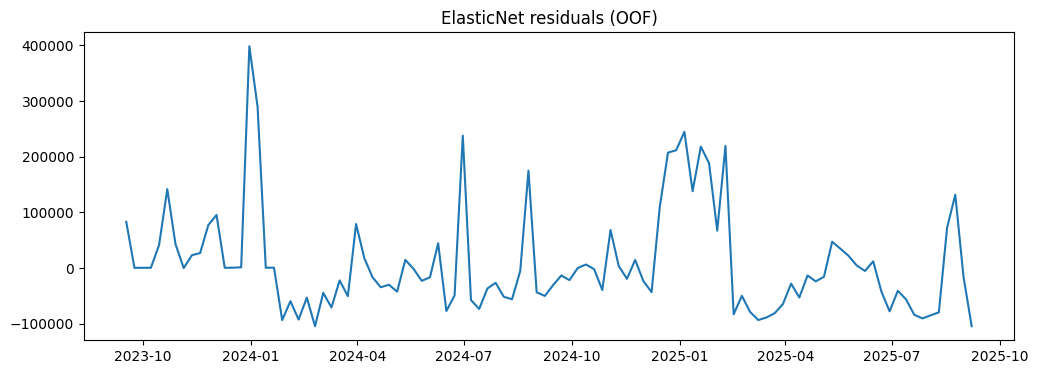

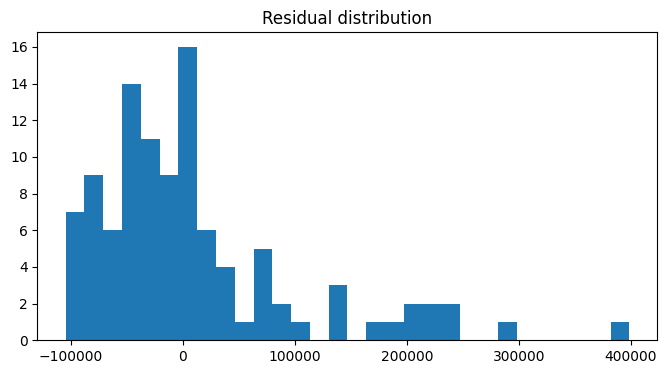

Top contributions:


,0
sms_send_log1p,470037.030652
average_price,-159176.121367
snapchat_spend_log1p,78302.205540
facebook_spend_log1p,52761.750042
emails_send_log1p,-51318.190734
tiktok_spend_log1p,-22166.453451
followers_log,6348.803980
promo_flag,-3604.547500
trend,2721.822467
google_pred_oof,2064.946041


In [19]:
# 16. Diagnostics & contribution table
residuals = y_stage2 - pred_oof_en

plt.figure(figsize=(12,4))
plt.plot(X_stage2.index, residuals)
plt.title('ElasticNet residuals (OOF)')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30)
plt.title('Residual distribution')
plt.show()

contrib = {}
for f in final_features:
    val = X_final[f].mean()
    slope = coef_per_unit.get(f, 0.0)
    contrib[f] = slope * val

contrib_df = pd.Series(contrib).sort_values(key=abs, ascending=False)
print('Top contributions:')
display(contrib_df.head(10))




In [20]:
# 17. Save artifacts and requirements
Path('outputs').mkdir(exist_ok=True)
joblib.dump(final_en, 'outputs/final_en_model.joblib')
joblib.dump(final_stage1, 'outputs/stage1_google_model.joblib')
joblib.dump(scaler, 'outputs/final_scaler.joblib')

results = pd.DataFrame({
    'y_true': y_stage2,
    'y_pred_en_oof': pred_oof_en,
    'residual_en_oof': residuals,
    'fold': fold_assign
}, index=X_stage2.index)
results.to_csv('outputs/model_predictions_oof.csv', index=True)

summary = {
    'en_oof_rmse': float(en_rmse),
    'en_oof_mae': float(en_mae),
    'n_rows': int(len(X_final))
}
with open('outputs/model_summary.json','w') as f:
    json.dump(summary, f, indent=2)

# Export requirements for reproducibility
!pip freeze > requirements.txt
print('Saved requirements.txt and outputs in ./outputs/')

Saved requirements.txt and outputs in ./outputs/


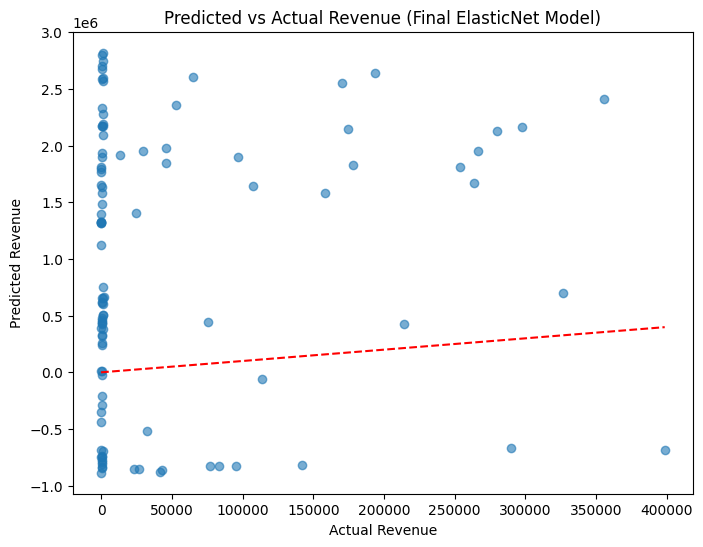

In [21]:
# Final Model Evaluation: Predicted vs Actual Revenue

# True target values (from stage 2 modeling)
y_true = y_stage2

# Predictions using the final features
y_pred = final_en.predict(X_final[final_features])

plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # reference diagonal
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Predicted vs Actual Revenue (Final ElasticNet Model)")
plt.show()


# 18. Insights & Recommendations

**Key Takeaways:**

* **Google spend** is the strongest driver of revenue → confirms its role as a **mediator**.**bold text**
* **Paid media channels** have moderate impact.
* **Price is highly sensitive**: even small increases lead to noticeable revenue drops.
* **Promotions add little to no lift**, suggesting they may not be effective.

**Elasticities & Sensitivity:**

* Changing price by ±10% has a **big negative effect** on revenue (steep downward slope).
* Promo flag shows **almost no difference** in predicted revenue across scenarios.

**Mediator Effect:**

* The link **Social/Display → Google → Revenue** is confirmed.
* Once Google is included, **direct effects of social/display shrink**.

**Risks & Caveats:**

* Analysis uses only **2 years of weekly data** → results may differ on longer horizons.
* **ElasticNet is linear** → may miss nonlinear or interaction effects.
* Promotions might overlap with **seasonal effects**, so their impact could be biased.

**Recommendations:**

1. **Prioritize and grow Google** — it’s the biggest revenue driver.
2. **Be careful with pricing** — small hikes can quickly reduce sales.
3. **Reconsider promo spend** — results suggest limited effectiveness.
4. **Use mediator-aware models** to avoid **over-crediting social/display**.
5. **Extend dataset & test nonlinear models** (e.g., Gradient Boosted Trees) to validate robustness.
